# Lab 3: Deep Networks


### Computational Graphs

![Computational Graph](image.png)

Ideally you would have to draw a computational graph and backprop through this to train a neural network. But Pytorch takes care of this using it's autograd library.

## Create Data

Input X - a 2D numpy array of size (num_samples, num_features) sampled from standard normal distribution. $X \sim \mathcal{N}(0, I)\,$

Weight w - a 1D numpy array of size (num_features) sampled from standard normal distribution. $w \sim \mathcal{N}(0, 1)\,$

Target y - a 1D numpy array of size (num_samples) generated from polynomials of columns of X, specifically,
$$y = \sum_{i=1}^{T}w_{i}x_{i}^{i}\, ,$$

where $T=$num_features, $x_{i}$ denotes the ith column of $X$

For example, if num_features=3 and $w=(3, 2, 1)^{T}$, then $y=x_{2}^{2} + 2x_{1} + 3$

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim

np.random.seed(333)
torch.manual_seed(333)

In [2]:
def polynomial(num_features, num_samples):
    w = np.random.normal(0, 1, (num_features,))
    X = np.random.normal(0, 1, (num_samples, num_features))
    y = 0
    for i in range(len(w)):
        y += w[i]*X[:, i]**i
        
    return (X, y)

def generate_data(num_features, num_samples, test_ratio=0.1):
    X, y = polynomial(num_features, num_samples)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(num_samples * test_ratio))
    
    return [X_train, X_test, y_train, y_test]

In [3]:
# Generate default dataset with 3 features (degree 2) and 10000 samples
data_deg2 = generate_data(3, int(1e4))

## Batch Gradient Descent

Let's first try to approximate this function with linear regression using gradient descent

Recall that in linear regression:
$$f(x) = X\theta$$

The $L_{2}$ lost function, given $n$ samples:

$$J(\theta) = \frac{1}{n}\|X\theta - y\|_{2}^{2}$$

The gradient of the lost function (for back propagation):

$$\nabla J(\theta) = \frac{2}{m}X^{T}(X\theta - y)$$

We update parameter $\theta$ by

$$\theta = \theta - \alpha \times \nabla J(\theta)$$

Where $\alpha$ is the step size

In [4]:
# Let's define helper functions
def plot_loss(res):
    best_theta, train_loss, test_loss = res
    x = np.arange(len(train_loss))
        
    plt.plot(x, train_loss, label="Train Loss")
    plt.plot(x, test_loss, label="Test Loss")
    
    plt.xlabel('Epochs/Steps')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

In [5]:
### The square loss function
def compute_loss(X, y, theta):
    """
    Given a set of X, y, theta, compute the average square loss for predicting y with X*theta.

    Args:
        X - the feature vector, 2D numpy array of size (num_samples, num_features)
        y - the label vector, 1D numpy array of size (num_samples)
        theta - the parameter vector, 1D array of size (num_samples)

    Returns:
        loss - the average square loss, scalar
    """
    loss = 0 #Initialize the average square loss
    
    ################ Your code here ################
    m = X.shape[0]
    d = (np.dot(X, theta) - y)
    loss = np.dot(d, d) / m

    return loss

### The gradient of the square loss function
def compute_gradient(X, y, theta):
    """
    Compute the gradient of the average square loss

    Args:
        X - the feature vector, 2D numpy array of size (num_samples, num_features)
        y - the label vector, 1D numpy array of size (num_samples)
        theta - the parameter vector, 1D numpy array of size (num_samples)

    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    
    ################ Your code here ################
    m = X.shape[0]
    d = (np.dot(X, theta) - y)
    grad = 2 * np.dot(X.T, d) / m

    return grad

In [6]:
def batch_grad_descent(data, alpha=0.01, num_step=1000):
    """
    Batch gradient descent to minimize the average square loss objective.

    Args:
        data - a list of 4 elements [X_train, X_test, y_train, y_test]
        alpha - step size in gradient descent
        num_step - number of steps to run

    Returns:
        best_theta - the set of parameters that achieves smallest loss on test data
        train_loss_hist - the history of average square loss on training data, 1D numpy array, (num_step)
        test_loss_hist - the history of average square loss on testing data, 1D numpy array, (num_step)
    """
    # Initialization
    X_train, X_test, y_train, y_test = data

    num_features = X_train.shape[1]
    theta = np.zeros(num_features)
    
    # Track performance
    best_test_loss = float('Inf')
    best_theta = theta
    test_loss_hist = []
    train_loss_hist = []
    loss_diff = 100
    i = 0
    ################ Your code here ################
    # Training loop
    while (loss_diff > 10**(-5)) and i <= num_step:
        grad = compute_gradient(X_train, y_train, theta)
        theta = theta - alpha * grad
        train_loss_hist.append(compute_loss(X_train, y_train, theta))
        test_loss_hist.append(compute_loss(X_test, y_test, theta))
        
        if test_loss_hist[i] < best_test_loss:
            best_theta = theta
        if len(test_loss_hist) >= 2:
            loss_diff = np.abs(test_loss_hist[-1] - test_loss_hist[-2])
        i = i+1

    return (best_theta, train_loss_hist, test_loss_hist)

Total time taken is 0.12232099999999946 seconds.


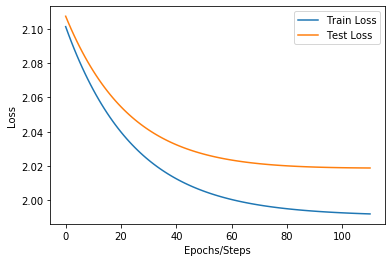

In [7]:
from time import perf_counter
batch_start_time = perf_counter()
res = batch_grad_descent(data_deg2)
batch_end_time = perf_counter()
print("Total time taken is {} seconds.".format(batch_end_time - batch_start_time))
plot_loss(res)

## Minibatch Gradient Descent

Batch gradient descent with very large training data can take a very long time to compute, since it requires looking at each training example to take a single gradient step. Hence in reality, we often use minibatch gradient descent. 

One pass through the training data is called an **epoch**. In each epoch, training data are divided into minibatches after **random shuffling**. During training, we sweep through the whole training set one minibatch at a time, and at each step, we want to

1. perform a parameter update using the **current batch of data**.
2. record training loss using the **current batch of data**.
3. record testing loss using the whole **testing set**

In [8]:
#######################################
### Minibatch gradient descent
def minibatch_grad_descent(data, batch_size=50, alpha=0.005, num_epoch=50):
    """
    Minibatch gradient descent to minimize the average square loss objective.

    Args:
        X - A tuple containing two elements (X_train, X_test), 
            each one of which is a numpy array of size (num_samples, num_features)
        y - A tuple containing two elements (y_train, y_test),
            each one of which is a numpy array of size (num_samples)
        batch_size - the number of samples per batch
        alpha - step size in gradient descent
        num_step - number of epochs to go through the whole training set

    Returns:
        best_theta - the set of parameters that achieves smallest loss on test data
        train_loss_hist - the history of average square loss on training data, 2D numpy array, (num_epoch, num_batches)
        test_loss_hist - the history of average square loss on testing data, 2D numpy array, (num_epoch, num_batches)
    """
    
    # Initialization
    X_train, X_test, y_train, y_test = data
    
    num_samples, num_features = X_train.shape
    num_batches = int(num_samples / batch_size)
    theta = np.ones(num_features) 
    order = np.arange(num_samples)
    
    train_loss_hist = []
    test_loss_hist = []
    i = 0
    
    # Track performance
    best_test_loss = float('Inf')
    best_theta = theta
    loss_diff = 100
    np.random.seed(432)
    ################ Your code here ################
    while (loss_diff > 10**(-5)) and i <= num_epoch:
        np.random.shuffle(order)
        minibatches = np.array_split(order, num_batches)
        i = i+1
        for j in range(num_batches):
            batch = minibatches[j]
            
            grad = compute_gradient(X_train[batch], y_train[batch], theta)
            theta = theta - alpha * grad
            train_loss_hist.append(compute_loss(X_train[batch], y_train[batch], theta))
            test_loss_hist.append(compute_loss(X_test, y_test, theta))

            if test_loss_hist[-1] < best_test_loss:
                best_theta = theta
            if len(test_loss_hist) >= 2:
                loss_diff = np.abs(test_loss_hist[-1] - test_loss_hist[-2])
            if loss_diff < 10**(-5):
                break

    
    return (best_theta, train_loss_hist, test_loss_hist)

In [4]:
minibatches = np.array_split(np.arange(10000), 10000)
minibatches

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69]),
 array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109]),
 array([110, 111, 112, 113, 114, 115, 116, 117, 118, 119]),
 array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129]),
 array([130, 131, 132, 133, 134, 135, 136, 137, 138, 139]),
 array([140, 141, 142, 143, 144, 145, 146, 147, 148, 149]),
 array([150, 151, 152, 153, 154, 155, 156, 157, 158, 159]),
 array([160, 161, 162, 163, 164, 165, 166, 167, 168, 169]),
 array([170, 171, 172, 173, 174, 175, 176, 177, 178, 179]),
 array([180, 181, 182, 183, 18

We observe that using the same dataset, batch gradient descent and minibatch gradient descent give rise to similar results

Total time taken is 0.018840299999993704 seconds.


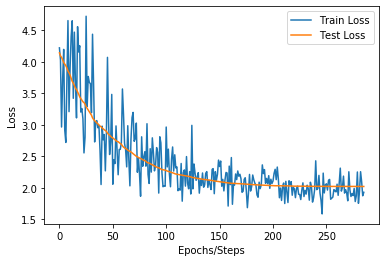

In [9]:
batch_start_time = perf_counter()
res = minibatch_grad_descent(data_deg2)
batch_end_time = perf_counter()
print("Total time taken is {} seconds.".format(batch_end_time - batch_start_time))
plot_loss(res)

## PyTorch Implementation

Now we modify *minibatch_grad_descent* to implement the above concept in PyTorch. Pay attention to how loss function and gradient update are implemented in PyTorch.

In [10]:
################ Your code here ################

In [11]:
# Converting data from numpy array to torch tensor
def array2tensor(data):
    res = []
    for d in data:
        res.append(torch.from_numpy(d).float())
    return res

In [12]:
# Training loop in PyTorch
def train(data, model, alpha=0.005, batch_size=50, num_epoch=50):
    X_train, X_test, y_train, y_test = data
    
    # Define loss function class, which contains both compute_loss and compute_gradient functionalities
    loss_fn = nn.MSELoss(reduction='mean')
    # Define method for updating parameters
    optimizer = optim.SGD(model.parameters(), lr=alpha)
    
    num_samples, num_features = X_train.shape
    num_batches = int(num_samples / batch_size)
    order = np.arange(num_samples)
    
    # Track performance
    best_test_loss = float('Inf')
    best_model = None
    train_loss_hist = []
    test_loss_hist = []
    loss_diff = 100
    i = 0

    ################ Your code here ################
    while (loss_diff > 10**(-5)) and i <= num_epoch:
        np.random.shuffle(order)
        minibatches = np.array_split(order, num_batches)
        i = i+1
        for j in range(num_batches):
            # Get batch input data of size (batch_size, num_features)
            batch = minibatches[j]

            # Set model to training mode and reset gradient
            model.train()
            model.zero_grad()

            # Make model prediction using current batch data
            y_pred = model(X_train[batch]).squeeze()
            # compute_loss
            train_loss = loss_fn(y_pred, y_train[batch])
            train_loss_hist.append(train_loss.item())

            # compute_gradient
            train_loss.backward()
            # Step into gradient descent direction. Perform parameter update
            optimizer.step()

            # Evaluating performance on test set
            with torch.no_grad():
                model.eval()
                test_loss_hist.append(loss_fn(model(X_test).squeeze(), y_test))
                # Keep track of the model that gives rise to minimal loss on test data
                if test_loss_hist[-1] < best_test_loss:
                    best_model = model.state_dict()
                if len(test_loss_hist) >= 2:
                    loss_diff = abs(test_loss_hist[-2]-test_loss_hist[-1])
                    
    return (best_model, train_loss_hist, test_loss_hist)

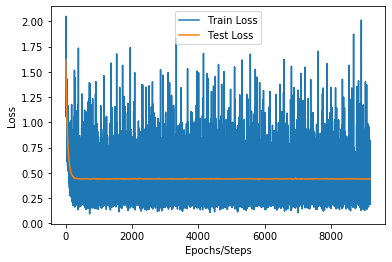

In [13]:
# Define network structure in PyTorch
class affineNet(nn.Module):
    def __init__(self, in_features, out_features=1):
        super(affineNet, self).__init__()
        self.net = nn.Linear(in_features, out_features)
    
    def forward(self, x):
        out = self.net(x)
        return out

# Define affineNet model instance with 3 input features
model = affineNet(3)
res = train(array2tensor(data_deg2), model)
plot_loss(res)

We know that our target $y$ is the second degree polynomials of X. Hence the above *affineNet*, which only contains one linear transformation, cannot effectively learn the non-linear relationship between $X$ and $y$. In the code below, I define another network *DeepNet* of Linear -- ReLU -- Linear. *DeepNet* is better at learning non-linear relationship between $X$ and $y$ (by including ReLU non-linear transformation), and gives rise to lower training and testing loss.

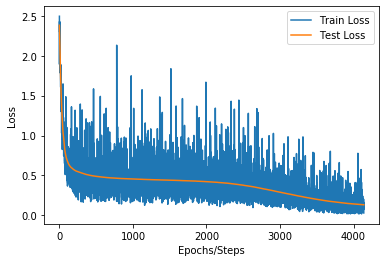

In [16]:
class DeepNet(nn.Module):
    def __init__(self, in_features, hidden_size=3, out_features=1):
        super(DeepNet, self).__init__()
        self.net = nn.Sequential(nn.Linear(in_features, hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size, out_features))
    
    def forward(self, x):
        out = self.net(x)
        return out
    
model = DeepNet(3)
res = train(array2tensor(data_deg2), model)
plot_loss(res)

We can make *DeepNet* even more complex by increase the hidden dimension from 3 to 6. This modified model converges faster and achieves lower loss compared to default setting of *DeepNet*

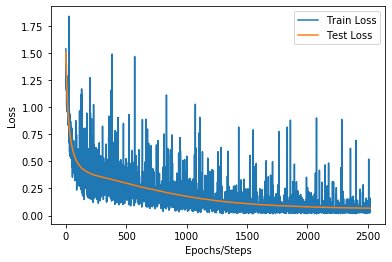

In [15]:
model = DeepNet(3, hidden_size=6)
res = train(array2tensor(data_deg2), model)
plot_loss(res)

We can approach this problem at a different angle by generating more complex dataset with higher degree polynomials of $X$. *DeepNet* trained on higher degree polynomials of X produces higher loss (y-axis in the two plots below).

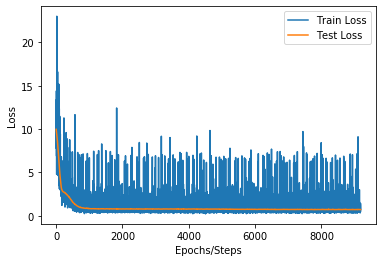

In [17]:
# Polynomial of degree 3
data_deg3 = generate_data(4, int(1e4))
model = DeepNet(4)
res = train(array2tensor(data_deg3), model)
plot_loss(res)

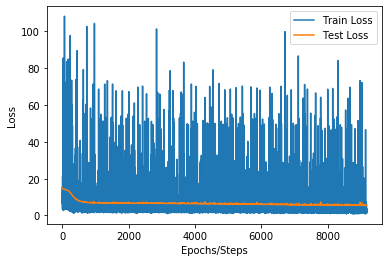

In [18]:
# Polynomial of degree 4
data_deg4 = generate_data(5, int(1e4))
model = DeepNet(5)
res = train(array2tensor(data_deg4), model)
plot_loss(res)